<a href="https://colab.research.google.com/github/hamig0har/EV-Detection-from-Energy-Consumption-Data/blob/main/Machine_Learning_Model_EV_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Attempt to load data
austin_data = pd.read_csv('/content/sample_data/15minute_data_austin.csv')
metadata = pd.read_csv('/content/sample_data/metadata.csv')

# Display the first few rows to inspect the data
austin_data_head = austin_data.head()
metadata_head = metadata.head()

print(austin_data_head, metadata_head)


   dataid             local_15min  air1  air2  air3  airwindowunit1  \
0     661  2018-11-21 15:15:00-06   0.0   NaN   NaN             NaN   
1     661  2018-11-21 15:30:00-06   0.0   NaN   NaN             NaN   
2     661  2018-11-21 15:45:00-06   0.0   NaN   NaN             NaN   
3     661  2018-11-21 16:00:00-06   0.0   NaN   NaN             NaN   
4     661  2018-11-21 16:15:00-06   0.0   NaN   NaN             NaN   

   aquarium1  bathroom1  bathroom2  bedroom1  ...  sprinkler1  sumppump1  \
0        NaN        NaN        NaN       NaN  ...         NaN        NaN   
1        NaN        NaN        NaN       NaN  ...         NaN        NaN   
2        NaN        NaN        NaN       NaN  ...         NaN        NaN   
3        NaN        NaN        NaN       NaN  ...         NaN        NaN   
4        NaN        NaN        NaN       NaN  ...         NaN        NaN   

   utilityroom1  venthood1  waterheater1  waterheater2  wellpump1  \
0           NaN        NaN           NaN       

**Data Pre-Processing**

-Handling Missing Values: Impute missing values with zeros for energy consumption columns, assuming no consumption or measurement was recorded.

-Sum the energy values across all consumption columns for each row to create the "total energy consumption" feature.

-Label the dataset with 1 for houses with an EV and 0 for those without, based on the dataids

In [ ]:
import numpy as np

# Assuming you've already loaded your datasets
# austin_data = pd.read_csv('/content/15minute_data_austin.csv')

# Step 1: Handle Missing Values
energy_columns = austin_data.columns[2:]  # Adjust if the structure is different
austin_data[energy_columns] = austin_data[energy_columns].fillna(0)
print("Step 1: Missing values handled.")

# Step 2: Add a 'total_energy' Column
austin_data['total_energy'] = austin_data[energy_columns].sum(axis=1)
print("Step 2: 'total_energy' column added. Sample data:\n", austin_data[['dataid', 'total_energy']].head())

# Step 3: Label the Data
ev_houses = [661, 1642, 2335, 4373, 4767, 6139, 7719, 8156, 9278]
austin_data['has_ev'] = austin_data['dataid'].apply(lambda x: 1 if x in ev_houses else 0)
print("Step 3: Data labeled. Distribution of labels:\n", austin_data['has_ev'].value_counts())

# Verification of preprocessing
print("\nPreprocessing verification complete. Sample data:\n", austin_data.head())




Step 1: Missing values handled.
Step 2: 'total_energy' column added. Sample data:
    dataid  total_energy
0     661       248.593
1     661       248.671
2     661       248.725
3     661       248.971
4     661       249.042
Step 3: Data labeled. Distribution of labels:
 0    559712
1    313574
Name: has_ev, dtype: int64

Preprocessing verification complete. Sample data:
    dataid             local_15min  air1  air2  air3  airwindowunit1  \
0     661  2018-11-21 15:15:00-06   0.0   0.0   0.0             0.0   
1     661  2018-11-21 15:30:00-06   0.0   0.0   0.0             0.0   
2     661  2018-11-21 15:45:00-06   0.0   0.0   0.0             0.0   
3     661  2018-11-21 16:00:00-06   0.0   0.0   0.0             0.0   
4     661  2018-11-21 16:15:00-06   0.0   0.0   0.0             0.0   

   aquarium1  bathroom1  bathroom2  bedroom1  ...  utilityroom1  venthood1  \
0        0.0        0.0        0.0       0.0  ...           0.0        0.0   
1        0.0        0.0        0.0      

**Feature Selection**

Considering that our primary interest is in predicting whether a house has an EV based on energy consumption, the total_energy column we added will be our main feature. However, if we decide that the time of day is significant (for instance, overnight charging might indicate an EV), we might also want to extract features from the local_15min timestamp, such as hour of the day. For simplicity, let's start with total_energy as our main feature.

**Why Random Forest?**

* Familiarity: Used Random Forest before so a good starting point

* Flexibility: Can handle both numerical and categorical variables well.


* Ease of Use: It's straightforward to implement and tune compared to Neural Networks

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Assuming 'austin_data' is your preprocessed DataFrame
features = ['total_energy']  # You can add more features here as shown below
X = austin_data[features]
y = austin_data['has_ev']

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Model training complete.")

# Making predictions on the testing set
y_pred = rf.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")


Extra code written to extract features from **local_15min column**

This code carries over from our earlier discussion of edge detection and the trends we saw when we inspected that.

Some features which we noticed when we inspected the ATCO dataset were **hours of day** when the EV charger went on. And we noticed that **weekday and weekend patterns** were slightly different.

We could extract these features from this particular dataset since it does give local 15 minute data alongside the date

In [ ]:
# Convert 'local_15min' to datetime
austin_data['local_15min'] = pd.to_datetime(austin_data['local_15min'], errors='coerce', utc=True)

# Extracting time features
austin_data['hour'] = austin_data['local_15min'].dt.hour  # Hour of the day
austin_data['day_of_week'] = austin_data['local_15min'].dt.dayofweek  # Day of the week, Monday=0, Sunday=6
austin_data['is_weekend'] = austin_data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)  # Weekend or not

# Verify the extracted features
print(austin_data[['local_15min', 'hour', 'day_of_week', 'is_weekend']].head())


features = ['total_energy', 'hour', 'is_weekend']  # Adjust features as needed
X = austin_data[features]
y = austin_data['has_ev']


**Further Evaluation of the model:**


**Precision, Recall, and F1 Score**:


*   Precision tells you out of all the instances the model predicted as positive, how many are actually positive.

*   Recall (or sensitivity) measures how many of the actual positives the model is able to identify.


*   F1 Score is the harmonic mean of precision and recall, providing a single metric to assess balance between them.

**ROC Curve and AUC**

The ROC Curve plots the true positive rate against the false positive rate at various threshold settings.
The Area Under the Curve (AUC) provides a single measure of how well the prediction model can distinguish between classes. Higher AUC indicates a better model.






Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77    112391
           1       0.56      0.21      0.30     62267

    accuracy                           0.66    174658
   macro avg       0.62      0.56      0.54    174658
weighted avg       0.63      0.66      0.61    174658



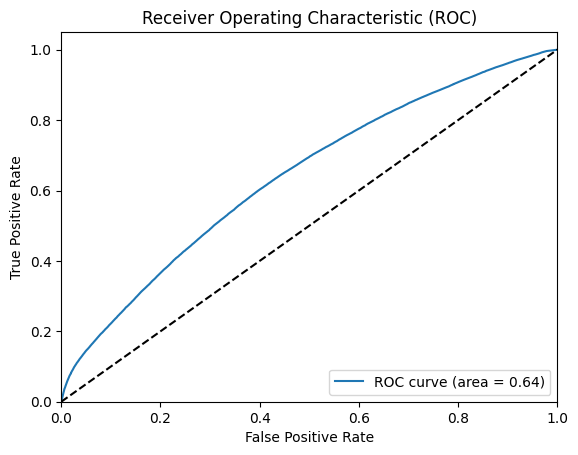

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Precision, Recall, F1 Score
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# ROC Curve and AUC
# Note: roc_curve and roc_auc_score are applicable for binary classification
if len(y_test.unique()) == 2:  # Checking if the task is binary classification
    y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC and AUC are not calculated for non-binary tasks.")


**Discussion of results:**

* Precision for class 0 (no EV) is 0.67, meaning that when the model predicts a house does not have an EV, it is correct 67% of the time.
* Precision for class 1 (has EV) is 0.56, meaning that when the model predicts a house has an EV, it is correct 56% of the time.
* Recall for class 0 is 0.91, indicating the model correctly identifies 91% of all actual no-EV instances.
* Recall for class 1 is 0.21, showing the model correctly identifies only 21% of all actual EV instances.
* F1-Score is a balance between precision and recall. For class 0, it's 0.77, which is relatively high, but for class 1, it's 0.30, indicating a poor balance for the EV class.

**The ROC-AUC graph**

* AUC = 0.5: The model has no discrimination capacity to distinguish between positive and negative class. It's as good as random guessing.
* 0.5 < AUC < 1.0: The model has a better than random chance of making correct predictions. The closer the AUC is to 1, the better it is. An AUC of 1 means the model perfectly distinguishes between all positive and negative class instances.
* AUC = 0.64: The model has a certain capacity to differentiate between houses with and without EVs, but there's significant room for improvement. It's better than random guessing but far from perfect.

**Biggest issues:**

* **High False Negatives:** A significant number of houses with EVs are being misclassified as not having EVs. This indicates a recall issue, particularly for the positive class (houses with EVs), where the model fails to capture most of the positive cases.

* **Unbalanced Precision and Recall:** The precision for predicting houses without EVs is reasonably good, but the recall for houses with EVs is quite low. This imbalance suggests that while the model is conservative in predicting a house has an EV (leading to a lower false positive rate), it also misses a lot of actual EV cases (high false negative rate).

**Reasons for the models perfomance:**

* **Lack of Features:** Relying solely on total_energy as the predictive feature might not capture all the nuances necessary to distinguish between houses with and without EVs. The energy consumption patterns might be too subtle or varied to be captured by a single aggregate value.

* **Time Ignored:** Time-based patterns in energy consumption will be crucial for identifying EV charging as seen from the observed ATCO data, especially since charging often occurs during specific times (e.g., overnight). Ignoring time-related features means missing out on potentially predictive patterns.

* **Complex Patterns Missed:** A more sophisticated model or additional features may capture patterns that might be missed in a random forest.

* **Data Imbalance:** If the dataset has a lot more instances of one class over the other, it could lead the model to be biased towards predicting the majority class. This seems to be reflected in the higher accuracy in predicting houses without EVs compared to those with EVs. So not only do we have limited data for EV homes, but we also have too much of one class (non-ev homes)

# **Next Steps**

**Feature Engineering:** Incorporating time-based features and perhaps looking into more granular energy consumption metrics or patterns over time could improve model performance.

**Address Data Imbalance:** By combining the New York Data set with this Austin dataset we will further enhance the overall data that we have for training and combining the ATCO data will help further.

To address the imbalance we could just get rid of some houses that dont have an EV as seen in the data.

**Model Complexity:** Exploring more complex models that can capture temporal patterns and interactions between features might yield better results. Models like Neural Networks or even time series analysis methods could be considered.

**Discussion with Academic Advisor to get his insight.**



**Further Enhancements on the Random Forest Model**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

**Step 2: Loading and Inspecting the Data**
Load dataset into pandas DataFrames. This code assumes the dataset and metadata are stored in CSV files.

In [ ]:
# Load data
austin_data = pd.read_csv('/content/sample_data/15minute_data_austin.csv')
metadata = pd.read_csv('/content/sample_data/metadata.csv')

# Display the first few rows to inspect the data
print(austin_data.head())
print(metadata.head())


   dataid             local_15min  air1  air2  air3  airwindowunit1  \
0     661  2018-11-21 15:15:00-06   0.0   NaN   NaN             NaN   
1     661  2018-11-21 15:30:00-06   0.0   NaN   NaN             NaN   
2     661  2018-11-21 15:45:00-06   0.0   NaN   NaN             NaN   
3     661  2018-11-21 16:00:00-06   0.0   NaN   NaN             NaN   
4     661  2018-11-21 16:15:00-06   0.0   NaN   NaN             NaN   

   aquarium1  bathroom1  bathroom2  bedroom1  ...  sprinkler1  sumppump1  \
0        NaN        NaN        NaN       NaN  ...         NaN        NaN   
1        NaN        NaN        NaN       NaN  ...         NaN        NaN   
2        NaN        NaN        NaN       NaN  ...         NaN        NaN   
3        NaN        NaN        NaN       NaN  ...         NaN        NaN   
4        NaN        NaN        NaN       NaN  ...         NaN        NaN   

   utilityroom1  venthood1  waterheater1  waterheater2  wellpump1  \
0           NaN        NaN           NaN       

**Step 3: Data Preprocessing**
Handle missing values, add a 'total_energy' column, and label the data based on the presence of EVs.

In [ ]:
# Handle Missing Values
austin_data.fillna(0, inplace=True)

# Add 'total_energy' Column
energy_columns = [col for col in austin_data.columns if col not in ['dataid', 'local_15min']]
austin_data['total_energy'] = austin_data[energy_columns].sum(axis=1)

# Label the Data
ev_houses = [661, 1642, 2335, 4373, 4767, 6139, 7719, 8156, 9278]
austin_data['has_ev'] = austin_data['dataid'].apply(lambda x: 1 if x in ev_houses else 0)

# Verification of preprocessing
print("\nPreprocessing verification complete. Sample data:\n", austin_data.head())


Preprocessing verification complete. Sample data:
    dataid             local_15min  air1  air2  air3  airwindowunit1  \
0     661  2018-11-21 15:15:00-06   0.0   0.0   0.0             0.0   
1     661  2018-11-21 15:30:00-06   0.0   0.0   0.0             0.0   
2     661  2018-11-21 15:45:00-06   0.0   0.0   0.0             0.0   
3     661  2018-11-21 16:00:00-06   0.0   0.0   0.0             0.0   
4     661  2018-11-21 16:15:00-06   0.0   0.0   0.0             0.0   

   aquarium1  bathroom1  bathroom2  bedroom1  ...  utilityroom1  venthood1  \
0        0.0        0.0        0.0       0.0  ...           0.0        0.0   
1        0.0        0.0        0.0       0.0  ...           0.0        0.0   
2        0.0        0.0        0.0       0.0  ...           0.0        0.0   
3        0.0        0.0        0.0       0.0  ...           0.0        0.0   
4        0.0        0.0        0.0       0.0  ...           0.0        0.0   

   waterheater1  waterheater2  wellpump1  winecooler

**Step 4: Extracting Time-based Features**
Convert the 'local_15min' column to datetime and extract relevant time-based features.

Some features which we noticed when we inspected the ATCO dataset were hours of day when the EV charger went on. And we noticed that weekday and weekend patterns were slightly different.

We could extract these features from this particular dataset since it does give local 15 minute data alongside the date

**THIS IS WHERE IMPROVEMENTS NEED TO BE MADE TO ENHANCE THE MODELS CAPABILITIES, AS MENTIONED IN THE REPORT**

In [ ]:
# Convert 'local_15min' to datetime
austin_data['local_15min'] = pd.to_datetime(austin_data['local_15min'], errors='coerce', utc=True)

# Extract time features
austin_data['hour'] = austin_data['local_15min'].dt.hour # Hour of the day
austin_data['day_of_week'] = austin_data['local_15min'].dt.dayofweek # Day of the week, Monday=0, Sunday=6
austin_data['is_weekend'] = austin_data['day_of_week'].apply(lambda x: 1 if x > 4 else 0) # Weekend or not

# Verify the extracted features
print(austin_data[['local_15min', 'hour', 'day_of_week', 'is_weekend']].head())



                local_15min  hour  day_of_week  is_weekend
0 2018-11-21 21:15:00+00:00    21            2           0
1 2018-11-21 21:30:00+00:00    21            2           0
2 2018-11-21 21:45:00+00:00    21            2           0
3 2018-11-21 22:00:00+00:00    22            2           0
4 2018-11-21 22:15:00+00:00    22            2           0


**Step 5: Feature Selection and Model Preparation**
Select your features and prepare the data for model training by splitting it into training and testing sets.

In [ ]:
# Feature Selection
features = ['total_energy', 'hour', 'is_weekend']
X = austin_data[features]
y = austin_data['has_ev']

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Step 6: Model Training and Evaluation**
Train a Random Forest Classifier with the selected features and evaluate its performance.

Model training complete.
Model Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72    112391
           1       0.48      0.43      0.45     62267

    accuracy                           0.63    174658
   macro avg       0.59      0.58      0.59    174658
weighted avg       0.62      0.63      0.62    174658



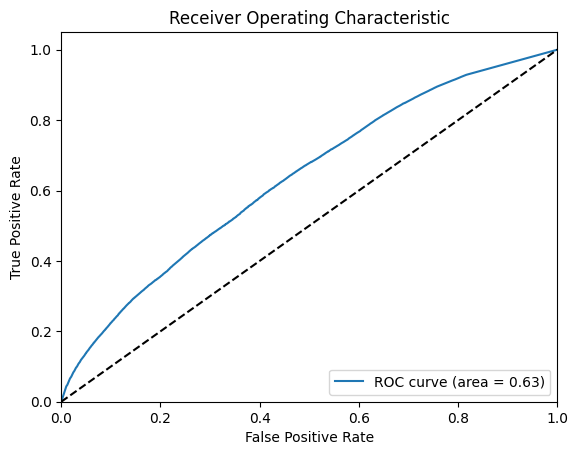

In [ ]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Model training complete.")

# Predictions
y_pred = rf.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC
y_pred_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**DISCUSSION OF RESULTS:**



*   **Model Accuracy:** The accuracy is now 0.63, which is a slight decrease from the previous model's accuracy of 0.66.
*   **Precision:** For class 0 (no EV), precision has slightly increased to 0.70 from 0.67, indicating a minor improvement in the accuracy of predictions for houses without an EV. For class 1 (has EV), precision has decreased to 0.48 from 0.56, suggesting that with the additional features, the model is less accurate in predicting houses with an EV.
*   **Recall:** The recall for class 0 has decreased to 0.74 from 0.91, and for class 1, it has improved to 0.43 from 0.21. This shows that the model is now better at identifying houses with an EV than before, but worse at correctly identifying houses without an EV.
*   **F1-Score:** The F1 score for class 0 decreased to 0.72 from 0.77, while for class 1, it increased to 0.45 from 0.30. The F1 score balances precision and recall, and the increase for class 1 suggests a better balance between these metrics for predicting EVs.

**ROC Curve and AUC:**

The AUC is 0.63, slightly lower than the previous model's AUC of 0.64. The AUC reflects the model's ability to distinguish between classes; a decrease suggests the model's discriminatory power has slightly reduced with the inclusion of time-based features.

**Discussion and Comparison**


It appears that adding time-based features had mixed effects on the model's performance:

**Improved Recall for EVs:** The model became better at identifying houses with EVs. This improvement could be because the time-based features capture charging patterns that are indicative of EV presence, such as overnight charging.

**Decreased Precision for EVs:** The addition of time-based features may have introduced some noise for predicting houses with EVs, leading to more false positives.


**Decreased Overall Accuracy and AUC:** The slight decrease in overall accuracy and AUC could be due to the model becoming less specialized in predicting the majority class (no EV) and more generalized across both classes.


**Reasons for Performance Changes**



*   Complexity of Time-based Patterns: Time-based features can be highly informative but also add complexity. If not modeled correctly, they can lead to the model picking up on noise rather than signal.
Overfitting to the Training Data: The model may be overfitting to the training data, which could explain why performance metrics like accuracy and AUC have slightly decreased.

*   Data Imbalance Still Impacting Performance: Even with time-based features, the class imbalance in the dataset can still be influencing the model's performance, and further strategies might be required to address this.

* Feature Interactions: The interactions between the time-based features and the total energy consumption might not have been captured effectively by the Random Forest, which could benefit from additional fine-tuning.


NEXT STEPS:

Combine the datasets for New York and Austin

In [ ]:
import pandas as pd

# Load Austin dataset
austin_data = pd.read_csv('/content/15minute_data_austin.csv')

# Load New York dataset
ny_data = pd.read_csv('/content/15minute_data_newyork.csv')

# Verify the structure of both datasets
assert list(austin_data.columns) == list(ny_data.columns), "Datasets have different structures"

# Combine datasets
combined_data = pd.concat([austin_data, ny_data], ignore_index=True)

# Sort by 'dataid' and 'local_15min'
combined_data.sort_values(by=['dataid', 'local_15min'], inplace=True)

print(combined_data.head())



        dataid             local_15min   air1   air2  air3  airwindowunit1  \
991173      27  2019-05-01 00:00:00-05  0.693  0.054   NaN             NaN   
991182      27  2019-05-01 00:15:00-05  0.554  0.006   NaN             NaN   
991158      27  2019-05-01 00:30:00-05  0.393  0.012   NaN             NaN   
991157      27  2019-05-01 00:45:00-05  0.801  0.060   NaN             NaN   
991288      27  2019-05-01 01:00:00-05  0.237  0.053   NaN             NaN   

        aquarium1  bathroom1  bathroom2  bedroom1  ...  sprinkler1  sumppump1  \
991173        NaN        NaN        NaN       NaN  ...         NaN        NaN   
991182        NaN        NaN        NaN       NaN  ...         NaN        NaN   
991158        NaN        NaN        NaN       NaN  ...         NaN        NaN   
991157        NaN        NaN        NaN       NaN  ...         NaN        NaN   
991288        NaN        NaN        NaN       NaN  ...         NaN        NaN   

        utilityroom1  venthood1  waterheater

**Step 4: Label the Data**


Label the data with a new column that indicates whether the house has an EV. We will also write a function to check if the 'car1' and 'car2' columns have non-zero values to confirm the houses with EVs.

In [ ]:
# List of houses with EVs in New York
ny_ev_houses = [5679, 1222, 3000, 9053, 27]

# List of houses with EVs in Austin
austin_ev_houses = [661, 1642, 2335, 4373, 4767, 6139, 7719, 8156, 9278]

# Labeling the data with EV presence
combined_data['has_ev'] = combined_data['dataid'].apply(lambda x: 1 if x in austin_ev_houses or x in ny_ev_houses else 0)

# Verify the labeling is correct
print(combined_data.groupby('dataid')['has_ev'].max())  # This will show 1 for houses with EVs and 0 for others

# Save the combined data to a CSV file for future use
combined_data.to_csv('/content/combined_data.csv', index=False)


dataid
27      1
142     0
387     0
558     0
661     1
914     0
950     0
1222    1
1240    0
1417    0
1642    1
2096    0
2318    0
2335    1
2358    0
2361    0
2818    0
3000    1
3039    0
3456    0
3488    0
3517    0
3538    0
3700    0
3996    0
4031    0
4283    0
4373    1
4550    0
4767    1
5058    0
5587    0
5679    1
5746    0
5982    0
5997    0
6139    1
7536    0
7719    1
7800    0
7901    0
7951    0
8156    1
8386    0
8565    0
9019    0
9053    1
9160    0
9278    1
9922    0
Name: has_ev, dtype: int64


**Step 5: Preprocess the Data**

Handle missing values, add a 'total_energy' column, and extract time-based features.

In [ ]:
# Fill missing values with zeros
combined_data.fillna(0, inplace=True)

# Add 'total_energy' column
energy_columns = [col for col in combined_data.columns if col.startswith('air') or col.startswith('car')]
combined_data['total_energy'] = combined_data[energy_columns].sum(axis=1)

# Convert 'local_15min' to datetime and extract time-based features
combined_data['local_15min'] = pd.to_datetime(combined_data['local_15min'], errors='coerce', utc=True)
combined_data['hour'] = combined_data['local_15min'].dt.hour
combined_data['day_of_week'] = combined_data['local_15min'].dt.dayofweek
combined_data['is_weekend'] = combined_data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)


**Step 6: Train the Random Forest Model on Combined Data**

Train the Random Forest Classifier using the combined data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Select features
features = ['total_energy', 'hour', 'is_weekend']
X = combined_data[features]
y = combined_data['has_ev']

print(f"Features DataFrame (X) dimensions: {X.shape}")
print(f"Labels DataFrame (y) dimensions: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Combined Data: {accuracy:.2f}")


Features DataFrame (X) dimensions: (1314885, 3)
Labels DataFrame (y) dimensions: (1314885,)
Model Accuracy on Combined Data: 0.78


**Step 7: Evaluate the Results**

Evaluate the performance using classification metrics and the ROC curve.

              precision    recall  f1-score   support

           0       0.85      0.84      0.84    182886
           1       0.64      0.65      0.65     80091

    accuracy                           0.78    262977
   macro avg       0.74      0.75      0.74    262977
weighted avg       0.78      0.78      0.78    262977

ROC AUC Score: 0.82


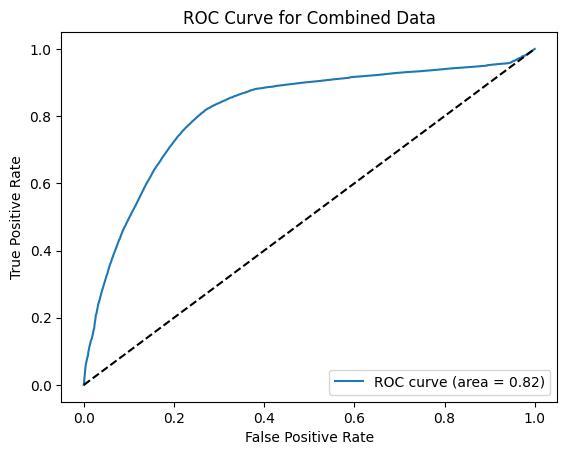

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Classification report
print(classification_report(y_test, y_pred))

# ROC curve and AUC
y_pred_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Combined Data')
plt.legend(loc="lower right")
plt.show()


**DISCUSSION OF RESULTS:**



*   **Model Accuracy:** There's an increase in overall accuracy from 0.63 to 0.78. This significant jump suggests that the model is better at generalizing when it has more data to learn from, which reduces overfitting to the patterns specific to the Austin dataset.

*   **Precision and Recall:**

    * For class 0 (no EV), precision has increased from 0.70 to 0.85, and recall has also increased from 0.74 to 0.84. The increase in both precision and recall for class 0 suggests that with more varied data from different geographic areas, the model has learned a more accurate representation of the no-EV class.

    * For class 1 (has EV), precision has increased from 0.48 to 0.64, and recall has gone up from 0.43 to 0.65. These improvements are substantial and indicate that the model is not only more accurate in predicting houses with EVs but also better at detecting the majority of actual EV cases.

* **F1-Score:** The F1-score for class 1 improved from 0.45 to 0.65, reflecting a better balance between precision and recall for the minority class. This improvement is particularly important in the context of imbalanced datasets where the minority class is often underrepresented.

* **ROC AUC Score:** An increase from 0.64 to 0.82 in the AUC score shows that the model's ability to distinguish between classes has significantly improved. This suggests that the combination of data from different cities has possibly introduced more distinctive patterns that help identify the presence of EVs more accurately.

**Reasons for Improved Performance**


* **Diversity of Data:** By combining data from Austin and New York, the model has access to a wider variety of household energy patterns, which may differ due to regional behaviors, climate, and other factors.

* **Increased Data Volume:** More data provides the model with more examples to learn from, which generally leads to better generalization and performance on unseen data.

* **Reduction in Overfitting:** The broader dataset reduces the model's risk of overfitting to the specific patterns present in the Austin data, enabling it to capture more general patterns that are indicative of EVs across different regions.

**Potential Flaws with the New Model**

* **Remaining Data Imbalance:** Despite the improvement, there's still a class imbalance that could be affecting the model's performance, especially for class 1 (has EV). This might be mitigated through resampling techniques or adjusting class weights.

* **Complex Interactions Not Captured:** The Random Forest model may still not be capturing all the complex interactions between features, especially temporal ones that might be better modeled with sequential models like RNNs.

* **Feature Engineering:** There might still be room for creating more informative features from the data, such as using domain knowledge to identify specific time slots associated with EV charging or household activities.

**NEXT STEPS:**

* Use ATCO's data alongside the above data to train and test the model.

* Model Experimentation: Explore more complex models, especially those that can model time-series data more effectively.

* Address Imbalance: Apply techniques like SMOTE for oversampling the minority class or adjust class weights within the model.

* Regional Feature Engineering: Develop features that capture regional differences, possibly by including weather data, which can affect energy usage patterns.

